# [CS-433] Practical Session on Generative Adversarial Networks
This is the practical session to the [CS-433 Machine Learning](https://edu.epfl.ch/coursebook/en/machine-learning-CS-433) Course at EPFL.

You can find the accompanying slides in the course materials, week **12**.

In this session, we will implement:
- **2-D Swiss Roll GAN.** a two-dimensional GAN - trained to generate samples from a Swiss-Roll manifold;
- Optional: **DCGAN on MNIST.** Implement a reduced model of [DCGAN](https://arxiv.org/pdf/1511.06434.pdf) (to generate $1\times 28 \times 28$ images), and train it on the MNIST dataset;
- Optional: **Conditional DCGAN on MNIST.** We will modify the above model, to use the class labels of the MNIST dataset.

---
We recommend running this notebook in [Colab](https://colab.research.google.com/). Training will be faster if using a GPU. 
To run this colab on GPU, change the runtime type: `Runtime > Change runtime type`, and select GPU from the dropdown. We can check which GPU is available by running the following command:





In [1]:
!nvidia-smi

Tue Dec  1 08:27:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Note:** *if experimenting with hyper-parameters, ensure you re-intialize the networks, by re-running the cells they are defined in.*

# Swiss-Roll toy experiment

https://theloopywhisk.com/wp-content/uploads/2019/01/Chocolate-Swiss-Roll_730px_featured.jpg

<center>
<img src="https://theloopywhisk.com/wp-content/uploads/2019/01/Chocolate-Swiss-Roll_730px_featured.jpg" width="380" height="287" alt="Swiss Roll"><br>
<i>
Chocolate Swiss Roll CC BY Image by <a href="https://theloopywhisk.com/wp-content/uploads/2019/01/Chocolate-Swiss-Roll_730px_featured.jpg">The Loopy Whisk</a></i>
</center>



In [2]:
#@title Setup
# Learning rate of the generator:
g_lr = 1e-4   #@param {type:"number",  min:0.000001}
# Learning rate of the discriminator:
d_lr = 5e-4   #@param {type:"number",  min:0.000001}
# batch size:
batch_size = 64   #@param {type:"integer",  min:1}
# dimension of tha latent vector
noise_dim = 100   #@param {type:"integer",  min:1}
# number of training iterations
total_iterations = 20000    #@param {type:"slider", min:1, max:50000, step:1} 


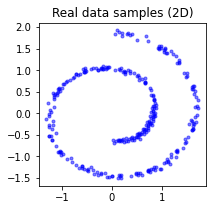

In [4]:
#@title Dataset
import torch
import sklearn.datasets  # we'll use it to create the Swiss Roll dataset
from matplotlib import pyplot as plt

def inf_data_gen(dataset=None, batch_size=None):
  """ Python infinite iterator (called python-generator) of samples
  following certain distribution.

  Example Usage:
  data_generator = inf_data_gen(dataset='swissroll', batch_size=64)
  sample = next(data_generator)
  """
  if dataset.lower() == 'swissroll':
    while True:
      data = sklearn.datasets.make_swiss_roll(
          n_samples=batch_size,
          noise=0.25
      )[0]
      data = data.astype('float32')[:, [0, 2]]
      data /= 7.5  # stdev plus a little
      yield data   # torch.from_numpy(data)
  else:
    raise NotImplementedError("Only supported dataset is SwissRoll")
# - Test -
data_generator = inf_data_gen(dataset='swissroll', batch_size=300)
sample = next(data_generator)
plt.figure(figsize=(3, 3))
plt.scatter(sample[:, 0], sample[:, 1], c='blue', marker='.', alpha=.5)
plt.title("Real data samples (2D)")
plt.show()

In [5]:
#@title Loss & GAN architecture: define MLPs for th Generator & the Discriminator
import torch.nn as nn
criterion = nn.BCELoss()  # Binary cross entropy

class GeneratorMLP(nn.Module):
    def __init__(self, dim_hidden=512, dim_out=2, noise_dim=100):
        super(GeneratorMLP, self).__init__()
        self.dim_hidden = dim_hidden
        self.dim_out = dim_out
        self.noise_dim = noise_dim
        self.net = nn.Sequential(
            nn.Linear(noise_dim, dim_hidden),
            nn.LeakyReLU(inplace=True),
            nn.Linear(dim_hidden, dim_hidden),
            nn.LeakyReLU(inplace=True),
            nn.Linear(dim_hidden, dim_hidden),
            nn.LeakyReLU(inplace=True),
            nn.Linear(dim_hidden, dim_out)
            )

    def forward(self, x):
        return self.net(x)


class DiscriminatorMLP(nn.Module):
    def __init__(self, dim_hidden=512, dim_gen_out=2):
        super(DiscriminatorMLP, self).__init__()
        self.dim_hidden = dim_hidden
        self.dim_gen_out = dim_gen_out
        self.net = nn.Sequential(
            nn.Linear(dim_gen_out, dim_hidden),
            nn.LeakyReLU(inplace=True),
            nn.Linear(dim_hidden, dim_hidden),
            nn.LeakyReLU(inplace=True),
            nn.Linear(dim_hidden, dim_hidden),
            nn.LeakyReLU(inplace=True),
            nn.Linear(dim_hidden, 1),
            nn.Sigmoid()
            )

    def forward(self, x):
        return self.net(x)

g_model = GeneratorMLP(noise_dim=noise_dim)
d_model = DiscriminatorMLP()
print(g_model)
print(d_model)

GeneratorMLP(
  (net): Sequential(
    (0): Linear(in_features=100, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=512, out_features=2, bias=True)
  )
)
DiscriminatorMLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=512, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


In [8]:
#@title training functions
def train_generator(gen, disc, loss=None, batch_size=64, device=torch.device('cpu')):
    """ Updates the params of disc['model'] (once).

    :param gen: dictionary with key 'model' [torch.nn.Sequential] and
                'optim' [torch.optim]
    :param disc: dictionary with key 'model' [torch.nn.Sequential]
    :param loss: [torch.nn.<loss>]
    :param batch_size: [int]
    :param device: torch.device('cuda') or torch.device('cpu')
    :return: None
    """
    loss = loss or nn.BCELoss()  # Binary cross entropy
    labels = torch.ones(batch_size, 1, device=device)
    noise = torch.randn(batch_size, gen['model'].noise_dim, device=device)

    gen['model'].zero_grad()
    loss(disc['model'](gen['model'](noise)), labels).backward()
    gen['optim'].step()  # update params of the generator
    return


def train_discriminator(gen, disc, data_sampler, n_steps=1, loss=None,
                        batch_size=64, device=torch.device('cpu')):
    """ Updates the params of disc['model'] n_steps times.

    :param gen: dictionary with key 'model' [torch.nn.Sequential]
    :param disc: dictionary with key 'model' [torch.nn.Sequential] and
                 'optim' [torch.optim]
    :param data_sampler: [python generator (https://wiki.python.org/moin/Generators)]
    :param n_steps: [int]
    :param loss: [torch.nn.<loss>]
    :param batch_size: [int]
    :param device: torch.device('cuda') or torch.device('cpu')
    :return: None
    """
    real_labels = torch.ones(batch_size, 1, device=device)
    fake_labels = torch.zeros(batch_size, 1, device=device)
    loss = loss or nn.BCELoss()  # Binary cross entropy

    for _ in range(n_steps):
        disc['model'].zero_grad()
        #  1. Backprop - D on real: maximize log(D(x)) + log(1 - D(G(z)))
        real_samples = torch.tensor(next(data_sampler), device=device)
        loss(disc['model'](real_samples), real_labels).backward()

        #  2. Backprop - D on fake:
        noise = torch.randn(batch_size, gen['model'].noise_dim, device=device)
        loss(disc['model'](gen['model'](noise)), fake_labels).backward()

        #  3. Update the parameters  of the generator
        disc['optim'].step()
    return

In [9]:
#@title train & store fake samples throughout training

if torch.cuda.is_available():
    g_model = g_model.cuda()
    d_model = d_model.cuda()
    criterion = criterion.cuda()
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
g_optim = torch.optim.Adam(g_model.parameters(), lr=g_lr, betas=(.5, .999))
d_optim = torch.optim.Adam(d_model.parameters(), lr=d_lr, betas=(.5, .999))

generator = {'model': g_model, 'optim': g_optim}
discriminator = {'model': d_model, 'optim': d_optim}

fixed_noise = torch.randn(300, noise_dim, device=device)
data_generator = inf_data_gen(dataset='swissroll', batch_size=batch_size)

plot_frequency = total_iterations // 100
fake_samples = []
for i in range(total_iterations):
  train_discriminator(generator, discriminator, data_sampler=data_generator,
                      loss=criterion, batch_size=batch_size, device=device)

  train_generator(generator, discriminator, loss=criterion,
                  batch_size=batch_size, device=device)

  if i % plot_frequency == 0 or (i+1) == total_iterations:
    fake_samples.append(generator['model'](fixed_noise).cpu().detach().numpy())


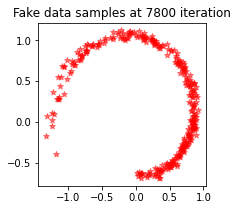

In [16]:
#@title Plot fake samples: select the iteration (0 and 100 are at begining and end of training, resp.)
iteration_plot_generator_samples = 39    #@param {type:"slider", min:0, max:100, step:1} 

fake_sample = fake_samples[iteration_plot_generator_samples]
plt.figure(figsize=(3, 3))
plt.scatter(fake_sample[:, 0], fake_sample[:, 1], c='red', marker='*', alpha=.5)
plt.title(f"Fake data samples at {iteration_plot_generator_samples*plot_frequency} iteration")
plt.show()
